In [21]:
import pandas as pd
from datetime import datetime

boe_price = pd.read_csv('BA Historical Prices.csv')
startDate = datetime.strptime('01/01/2017', '%m/%d/%Y')
endDate = datetime.strptime('08/01/2017', '%m/%d/%Y')

def convetFloat(x):
    x = x.replace(',','')
    try:
        return float(x)
    except:
        return None

boe_price['Date'] = boe_price['Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))
boe_price['Volume'] = boe_price['Volume'].apply(convetFloat)

boe_price = boe_price[boe_price.Date > startDate]
boe_price = boe_price[boe_price.Date < endDate]
print boe_price.head(5)
print len(boe_price)

Y = boe_price['Close'].values
dates = boe_price['Date'].values

dates = map(lambda x: datetime.utcfromtimestamp(x.astype(datetime)/1e9), dates)

          Date    Open    High     Low   Close      Volume
134 2017-07-31  241.85  246.49  241.82  242.46   5777021.0
135 2017-07-28  240.82  242.00  238.55  241.27   4602381.0
136 2017-07-27  237.13  242.68  236.70  241.00  10858711.0
137 2017-07-26  223.48  233.98  223.02  233.45  14135155.0
138 2017-07-25  213.22  214.00  211.95  212.46   2888194.0
151


In [ ]:
# import tweets
# These tweets are relvant to Boeing Co., which is crawled by using Twitter API, posted from 1/1/2017 to 1/8/2017
# Link to download the data http://www.dcs.gla.ac.uk/~anjie/be_files/

import os, pickle
tweets_files = '/Volumes/anjie/tr.anjie/be_files/'
tweets_data = {}
days_ms = 8.64e+7
for file in os.listdir(tweets_files):
    with open(os.path.join(tweets_files,file)) as f:
        tmp = pickle.load(f)
        for tweet in tmp:
            tmp_date = datetime.fromtimestamp(float(tweet['timestamp_ms'])/1000.0)
            if tmp_date >= startDate and tmp_date <= endDate:
                tmp_date = tmp_date.replace(minute=0, hour=0, second=0, microsecond=0)
                tweets_data.setdefault(tmp_date, []).append(tweet)

In [175]:
print('Total number of tweets relvant to Beoing is %d.' % sum([len(tweets_data[k]) for k in tweets_data]))

Total number of tweets relvant to Beoing is 279972.


In [24]:
# Simple Twitter sentiment analysis, tools from https://github.com/gt-big-data/twitter-api-sentiment-analysis
import re
import sys
import json

def get_tweet_sentiment(tweet_dict, weights):
    score = 0.0
    text = ""
    if u'text' in tweet_dict:
        utf8_text = tweet_dict[u'text']
        text = utf8_text
        toks = re.split('\s+', utf8_text.lower())
        for word in toks:
            word = re.sub('\W', '', word)
            if word in weights:
                score += weights[word]
        score = min(6, score)
        score = max(-6, score)
        for word in toks:
            word = re.sub('\W', '', word)
            if word not in weights and len(word) > 3:
                weights[word] = 0

    return score, text

def readWeights():
    weights = {}
    with open('sentiments.txt') as f:
        for line in f:
            toks = re.split('\s+', line.strip().lower()) 
            if len(toks) == 2:
                word = toks[0]
                word = re.sub('\W', '', word)
                weights[word] = float(toks[1])
    return weights

weights = readWeights()

In [206]:
# generate feature for classification/regression
# these features are obtained from 279972 tweets 
import numpy as np
tweets_vec = []

for d in dates:
    tws = tweets_data[d]
    vec = []
    
    num_ht = .0
    frac_ht = .0
    
    num_mentions = .0
    frac_mentions = .0
    
    num_URL = .0
    frac_URL = .0
    
    num_tweets = float(len(tws))
    sentiment_score = []
    for tw in tws:
        sentiment_score.append(get_tweet_sentiment(tw,weights)[0])
        
        num_ht += len(tw['entities']['hashtags'])
        if tw['entities']['hashtags']: frac_ht += 1
            
        num_mentions += len(tw['entities']['user_mentions'])
        if tw['entities']['user_mentions']: frac_mentions += 1
            
        num_URL += len(tw['entities']['urls'])
        if tw['entities']['urls']: frac_URL += 1
            
    frac_ht /= len(tw)
    frac_mentions /= len(tw)
    frac_URL /= len(tw)
    
    vec.append(num_ht)
    vec.append(frac_ht)
    vec.append(num_mentions)
    vec.append(frac_mentions)
    vec.append(num_URL)
    vec.append(frac_URL)
    vec.append(num_tweets)
    

    hist,_ = np.histogram(sentiment_score, bins=5)
    vec.extend(hist.tolist())
    tweets_vec.append(vec)
    
    
X = np.array(tweets_vec)
from sklearn.preprocessing import normalize
X = normalize(X, axis=1)
print X.shape

(151, 12)


<a id='fig1'></a>
### Figure 1

This figure is the data visualization of the data.
We constuct 7 contextual features from Boeing Co. related tweets over time: the number of tweets per day, the number of mention, sentiment scores, etc.
First, PCA is applied to obtain the most significant two components (i.e. x and y in the figure). Second, we apply kmean clustering. Then, the stock price together with x and y are plotted with 3 clusters (3 different colors). 

Each dot in the figure represent the stock price of a day associated with two PCA components.

In general, there seems a inclined plane in the 3D plot, which implies a lower x and a higher y can contribute a higher stock price. 
3 clustering indicated 3 categories. The blue cluster can potentially indicated a good stock price while the red one is the worst. 

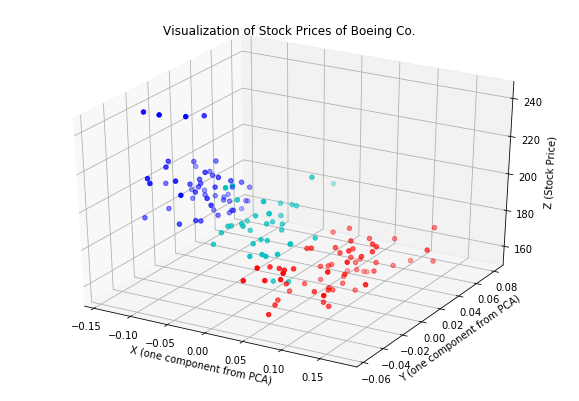

In [210]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

pca = PCA(n_components=2)
pca.fit(X)
X_ = pca.transform(X)

kmeans = KMeans(n_clusters=3).fit(X)
lables = kmeans.labels_


fig = plt.figure(figsize=(10,7))
c = ['b','r','c', 'm', 'y']
ax = fig.add_subplot(111, projection='3d')
count = 0
for l in list(set(lables)):
    ids = map(lambda x: x[0], filter(lambda x: x[1]==l, list(enumerate(lables))))
    ax.scatter(X_[ids,0], X_[ids,1], Y[ids], color=c[count])
    count += 1

ax.set_xlabel('X (one component from PCA)')
ax.set_ylabel('Y (one component from PCA)')
ax.set_zlabel('Z (Stock Price)')
plt.title('Visualization of Stock Prices of Boeing Co.')

plt.show()

<a id='fig2'></a>
### Figure 2

A linear model is applied using the 7 Twitter contextual features and the stock price day by day.
The figure lists the predicted and observed stock price by dots and each dot represents a day
The more the spot close to the line (y=x), the more accuarcy the preict is.

In [216]:
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC

# feature selection
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
sm = SelectFromModel(lsvc, prefit=True)
X_ = model.transform(X)


# regression model
lr = linear_model.LassoLars(alpha=.1)
# lr = linear_model.LinearRegression()

predicted = cross_val_predict(lr, X_, Y, cv=10)

# lr.fit(X,Y)
# print lr.coef_

fig, ax = plt.subplots()
ax.scatter(Y, predicted)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Obserived Prices')
ax.set_ylabel('Predicted Prices')
plt.title('Stock of Boeing Co.')
plt.show()

ValueError: Unknown label type: 'continuous'